<a href="https://colab.research.google.com/github/GabrielaRomoM/TAM-2025-2/blob/main/Tareas/TAM_180925.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerias

In [61]:
import numpy as np
import matplotlib.pyplot as plt

# Librerías para modelos y preprocesamiento
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_score, ShuffleSplit
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error as MSE

# Generación de Datos Simulados

Sea una señal determinística $t^*(x)$ definida en el dominio $\in \mathbb{R}$ .La observación medida $t(x)$ se ve afectada por ruido aditivo gaussiano:

$$t(x) = t^*(x) + n(x), \qquad n(x) \sim \mathcal{N}(0, \sigma_n^2)$$


donde $\sigma_n^2$ es la varianza del ruido, que puede definirse a partir de la relación señal a ruido (SNR):

$$\text{SNR}_{\mathrm{dB}} = 10 \log_{10} \left( \frac{P_{x}}{P_{n}} \right),
\qquad P_{n} = \frac{P_{x}}{10^{\text{SNR}_{\mathrm{dB}}/10}}$$

In [62]:
# Esta función calcula la varianza del ruido gaussiano necesario
# para obtener una señal con un SNR (Signal-to-Noise Ratio) dado en dB
def var_snr(x, snrdB):
    # x: vector de datos de la señal limpia
    # snrdB: SNR en dB
    Px = np.mean(x**2)  # estimador de potencia media de la señal
    return Px / (10**(snrdB/10))

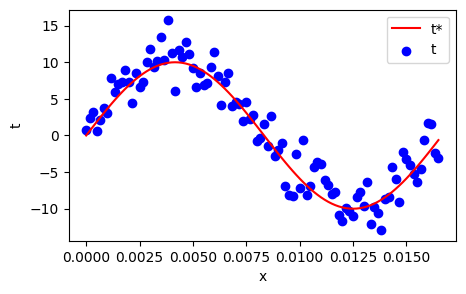

In [63]:
Fo = 60       # frecuencia fundamental señal coseno
A = 10        # amplitud de la señal
To = 1 / Fo   # período fundamental
Fs = 100 * Fo # frecuencia de muestreo (cumple Nyquist Fs >= 2Fo)

# Vector de entrada en un periodo con pasos según Fs
X = np.arange(0, To, 1 / Fs)
snrdB = 10  # nivel de ruido en dB

# Señal limpia (objetivo)
tt = A * np.sin(2 * np.pi * Fo * X)

# Señal con ruido Gaussiano aditivo
t = A * np.sin(2 * np.pi * Fo * X) + np.sqrt(var_snr(tt, snrdB)) * np.random.randn(len(X))

# Redimensionar para sklearn (muestras en filas)
X = X.reshape(-1, 1); t = t.reshape(-1, 1)

# Graficar señal limpia vs señal con ruido
plt.figure(figsize=(5, 3))
plt.plot(X, tt, c='r', label='t*') # Señal limpia
plt.scatter(X, t, c='b', label='t') # Señal con ruido
plt.legend(); plt.xlabel('x'); plt.ylabel('t')
plt.show()

# Ajuste polinomial con regularización (Ridge)

**Modelo Polinomial:**

La aproximación de $t^*(x)$ se realiza usando un modelo polinomial de grado $Q$:

$$\hat{t}(x) = w_0 + w_1 x + w_2 x^2 + \dots + w_Q x^Q = \mathbf{w}^\top \boldsymbol{\phi}_Q(x)$$

donde:

- $\boldsymbol{\phi}_Q(x) = [x, x^2, \dots, x^Q]^\top$ es el vector de características polinómicas,
- $\mathbf{w} \in \mathbb{R}^Q$ es el vector de coeficientes.

**Estimación por mínimos cuadrados:**

Los parámetros se determinan resolviendo el problema de mínimos cuadrados ordinarios (OLS), el cual corresponde a la minimización del error cuadrático medio (ECM):

$$\min_{\mathbf{w}} \frac{1}{N} \sum_{i=1}^{N}\big( t(x_i) - \mathbf{w}^\top \boldsymbol{\phi}_Q(x_i) \big)^2$$

**Regularización Rigde (L2):**

Para evitar sobreajuste, se añade un término de penalización $L_2$ a la función de costo:

$$\min_{\mathbf{w}} \frac{1}{N} \sum_{i=1}^{N} \big( t(x_i) - \mathbf{w}^\top \boldsymbol{\phi}_Q(x_i) \big)^2 + \lambda \|\mathbf{w}\|_2^2$$

donde $\lambda \geq 0$,  es el parámetro de regularización. Valores grandes de $\lambda$ producen modelos más simples.

**Complejidad:**

Al aumentar $Q$ (grado del polinomio):

- **Sesgo** disminuye (mejor ajuste de entrenamiento),
- **Varianza** aumenta (mayor sensibilidad al ruido).

Se produce la clásica **curva en U** del error de prueba (o error CV):

$$\text{ECM}_{\text{CV}}(Q) \approx \text{Sesgo}^2(Q) + \text{Varianza}(Q) + \sigma_n^2$$

El $Q$ óptimo minimiza $\text{ECM}_{\text{CV}}$ y ofrece el mejor compromiso entre sesgo y varianza

In [64]:
# Generación de representación polinomial
Q = 4  # grado del polinomio
phiQ = PolynomialFeatures(degree=Q)
Phi = phiQ.fit_transform(X)  # Representación polinómica de X

# Partición de datos (train/test)
rs = ShuffleSplit(n_splits=1, random_state=0, test_size=0.2)
for i, (train_i, test_i) in enumerate(rs.split(X)):
    print(f"Partición {i}")

# Regresor con regularización Ridge (mínimos cuadrados regularizados)
lambdaR = 1e-15  # hiperparámetro de regularización
reg_mc = Ridge(alpha=lambdaR)

# Se ordenan los índices para graficar en orden
train_i = np.sort(train_i); test_i = np.sort(test_i)

# Entrenamiento del modelo
reg_mc.fit(Phi[train_i], t[train_i])

# Predicción sobre conjunto de test
t_mc = reg_mc.predict(Phi[test_i])

Partición 0


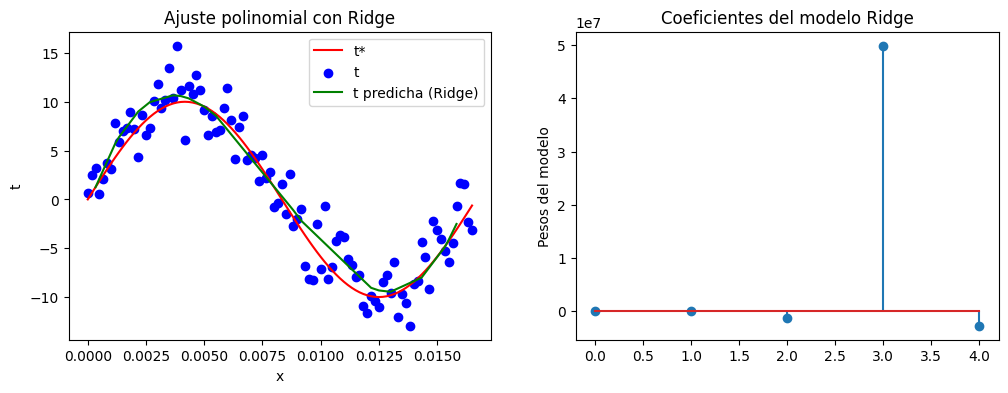

In [65]:
# Gráfica de la regresión ajustada
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(X, tt, c='r', label='t*') # Real
plt.scatter(X, t, c='b', label='t') # Con ruido
plt.plot(X[test_i], t_mc, c='g', label='t predicha (Ridge)')
plt.legend(); plt.xlabel('x'); plt.ylabel('t')
plt.title('Ajuste polinomial con Ridge')
plt.subplot(122)
# Visualización de los coeficientes del modelo
plt.stem(reg_mc.coef_); plt.ylabel('Pesos del modelo')
plt.title('Coeficientes del modelo Ridge'); plt.show()

## Analisis de error vs complejidad (Grado del polinomio)

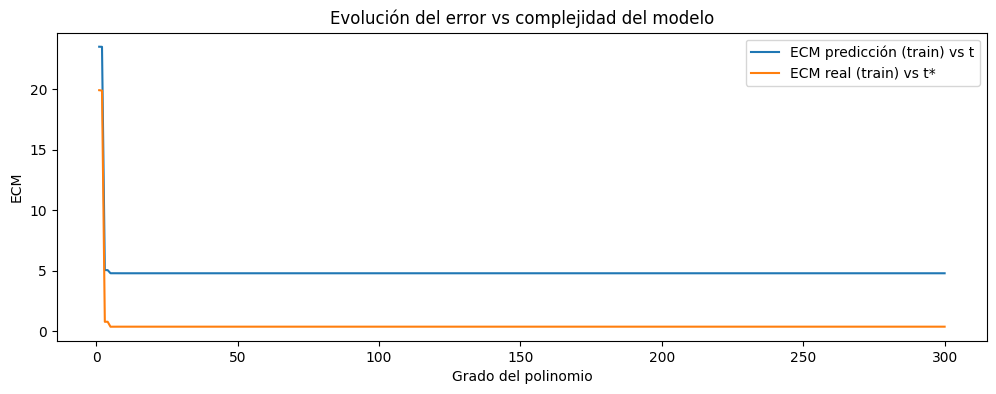

In [66]:
Qmax = 300  # Grado máximo del polinomio
grados = range(1, Qmax+1)
ecm_pred, ecm_real = [], []

# Se calcula ECM para cada grado del polinomio
for Q in grados:
    phi = PolynomialFeatures(degree=Q, include_bias=False)  # se evita el sesgo duplicado
    Phi = phi.fit_transform(X)

    reg = LinearRegression(fit_intercept=True)
    reg.fit(Phi, t.ravel())

    yhat = reg.predict(Phi)

    # ECM comparado contra señal ruidosa (predicción)
    ecm_pred.append(MSE(t.ravel(), yhat))
    # ECM comparado contra señal limpia (error real)
    ecm_real.append(MSE(tt.ravel(), yhat))

# Gráfico de ECM vs grado del polinomio
plt.figure(figsize=(12, 4))
plt.plot(grados, ecm_pred, label='ECM predicción (train) vs t')
plt.plot(grados, ecm_real, label='ECM real (train) vs t*')
plt.xlabel('Grado del polinomio'); plt.ylabel('ECM')
plt.title('Evolución del error vs complejidad del modelo')
plt.legend(); plt.show()

# Cross validation y selección de grado del polinomio (OLS)

El error de generalización se estima mediante **K-Fold Cross-Validation**:

$$\text{ECM}_{CV} =  \frac{1}{K} \sum_{k=1}^{K} \left[ \frac{1}{|D_{\text{test}}^{(k)}|} \sum_{x_i \in D_{\text{test}}^{(k)}} \big( t(x_i) - \hat{t}^{(k)}(x_i) \big)^2 \right]$$

donde $\hat{t}^{(k)}(x)$ es el modelo entrenado con los $K-1$ folds restantes.

Es decir, para cada fold (k) hay un entrenamiento con (k-1) bloques, donde se evalua cada bloque restante. Y el error del test es el promedio de cada fold (k) entrenado.

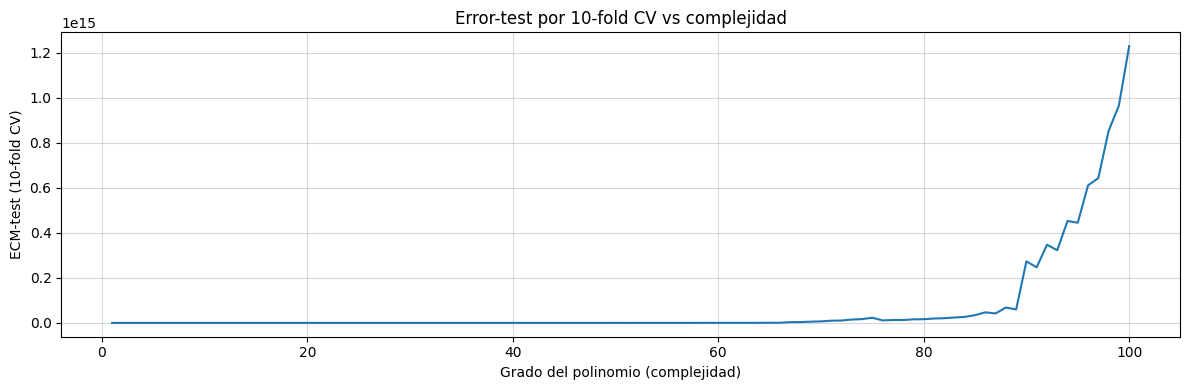

In [67]:
# Normalizamos los datos X al rango [-1, 1] para mejorar la estabilidad numérica
x_unit = 2 * (X - X.min()) / (X.max() - X.min()) - 1

# (OPCIONAL) AUMENTAR EL RUIDO PARA VER MEJOR LA "U"
# Si se quiere visualizar un error más pronunciado (curva en U más clara),
# podemos aumentar el ruido reduciendo la relación señal/ruido (SNR).
# Para hacerlo, descomenta estas líneas y vuelve a generar t:
snrdB = 0  # Relación señal/ruido en dB (0 dB = ruido alto)
noise = np.sqrt(var_snr(tt, snrdB)) * np.random.randn(len(X))
t = (tt + noise).ravel()

# Configurar validación cruzada K-FOLD
# Se utiliza 10-fold CV para estimar el error de generalización.
cv = KFold(n_splits=10, shuffle=True, random_state=0)  # Se barajan los datos para mayor robustez

# Entrenamiento de modelos polinomiales y evaluación ECM
Qmax = 100                 # Máximo grado de polinomio a probar
grados = range(1, Qmax+1)  # Lista de grados del 1 al Qmax
ecm_cv = []                # Lista para almacenar el error de validación cruzada

for Q in grados:
    # Se crea un pipeline: características polinomiales + regresión lineal OLS
    # OLS sin regularización permite ver claramente el sobreajuste
    model = make_pipeline(
        PolynomialFeatures(degree=Q, include_bias=False),
        LinearRegression(fit_intercept=True))
    # Se calcula el ECM (negativo porque cross_val_score lo devuelve negativo)
    scores = cross_val_score(
        model, x_unit, t.ravel(),
        scoring="neg_mean_squared_error", cv=cv)
    ecm_cv.append(-scores.mean())  # Se guarda el ECM promedio

# Gráfica del ECM vs Grado del polinomio (Complejidad)
plt.figure(figsize=(12, 4))
plt.plot(grados, ecm_cv)
plt.xlabel('Grado del polinomio (complejidad)'); plt.ylabel('ECM-test (10-fold CV)')
plt.title('Error-test por 10-fold CV vs complejidad')
plt.grid(True, alpha=0.5); plt.tight_layout(); plt.show()